<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [104]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:


import torchvision.transforms as transforms



from torchvision.models import resnet18
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [69]:
# Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Import data

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [71]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2025-06-01 19:49:11--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2025-06-01 19:49:11--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip.1’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.06s   

2025-06-01 19:49:12 (98.9 MB/s) - ‘images_evaluation.zip.1’ save

In [5]:
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [72]:
def read_alphabets(alphabet_directory_path):
    """
    Reads all the characters from a given alphabet_directory
    Args:
      alphabet_directory_path (str): path to diretory with files
    Returns:
      datax (np.array): array of path name of images
      datay (np.array): array of labels
    """
    datax = []  # all file names of images
    datay = []  # all class names

    for elem in os.listdir(alphabet_directory_path):
        original, rot90, rot180, rot270 = [], [], [], []

        path = alphabet_directory_path.split("/")[-2] + "/" + elem
        datay += [path]
        datay += [path + "_90"]
        datay += [path + "_180"]
        datay += [path + "_270"]

        #print(elem)

        for character in os.listdir(alphabet_directory_path + elem):
            filename = alphabet_directory_path + elem + "/" + character
            image = cv2.resize(cv2.imread(filename), (28, 28))
            image_rot90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
            image_rot180 = cv2.rotate(image, cv2.ROTATE_180)
            image_rot270 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

            original.append(image)
            rot90.append(image_rot90)
            rot180.append(image_rot180)
            rot270.append(image_rot270)

        datax += [original]
        datax += [rot90]
        datax += [rot180]
        datax += [rot270]

    return np.array(datax), np.array(datay)

In [73]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None

    results = [read_alphabets(base_directory + '/' + directory + '/') for directory in os.listdir(base_directory)]

    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [74]:
trainx, trainy = read_images('images_background')

In [75]:
testx, testy = read_images('images_evaluation')

In [77]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((3856, 20, 28, 28, 3), (3856,), (2636, 20, 28, 28, 3), (2636,))

## Create samples

In [78]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls][0]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append(sample_cls)

    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })


In [79]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
    #make a grid
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

    plt.figure(figsize=(16, 7))
    plt.imshow(out.permute(1, 2, 0))

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

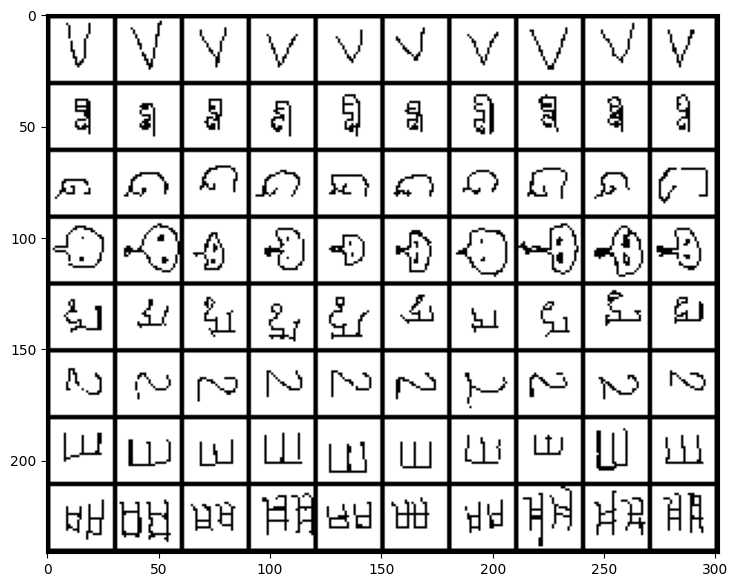

In [80]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [81]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [82]:
# pass your code
class Encoder(nn.Module):
    def __init__(self, input_channels, output_dim):

        super().__init__()

        self.conv_layers = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.conv_layers(x)
        x = self.fc(x)
        return x

### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [83]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        self.encoder = encoder

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim))
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat (predict)
        """
        sample_images = sample['images']
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]

        x_support = x_support.reshape(-1, *x_support.shape[2:]).to(device)
        x_query = x_query.reshape(-1, *x_query.shape[2:]).to(device)

        z_support = self.encoder(x_support)
        z_query = self.encoder(x_query)

        z_support = z_support.view(n_way, n_support, -1)

        prototypes = z_support.mean(dim=1)
        dists = torch.cdist(z_query, prototypes)
        log_p_y = F.log_softmax(-dists, dim=1)

        target_inds = torch.arange(n_way).reshape(n_way, 1).cuda()
        target_inds = target_inds.expand(n_way, n_query).reshape(-1)

        loss_val = -log_p_y.gather(1, target_inds.unsqueeze(1)).mean()

        _, y_hat = log_p_y.max(1)
        acc_val = (y_hat == target_inds).float().mean()


        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat
            }

In [84]:
def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = Encoder(
        input_channels=kwargs.get('x_dim')[0],
        output_dim=kwargs.get('z_dim', 64)
    ) # your code

    return ProtoNet(encoder)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [85]:
import wandb
import matplotlib.pyplot as plt

In [86]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  # epochs done so far
    stop = False  # status to know when to stop

    train_acc = []
    train_loss = []
    wandb.init(project="hw4", name = "run1", config={"n_way" : n_way,
                                                     "n_support" : n_support,
                                                     "n_query" : n_query,
                                                     "max_epoch" : max_epoch,
                                                     "epoch_size" : epoch_size})

    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch + 1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        scheduler.step()

        wandb.log({
            "train_loss": epoch_loss,
            "train_accuracy": epoch_acc
        })

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    epoches = np.arange(1, max_epoch + 1, 1)
    axes[0].plot(epoches, train_loss)
    axes[1].plot(epoches, train_acc)

    axes[0].set_title("train without simCLR")
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss")

    axes[1].set_title("train without simCLR")
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

In [87]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_x = trainx
train_y = trainy

n_way = 60
n_support = 5
n_query = 5
max_epoch = 5
epoch_size = 2000

epoch,▁▃▅▆█
train_accuracy,▁▇███
train_accuracy_simclr,▄▃▃▄▃▃█▂▄▆▃▁▃▃█▄▄▄▃▆
train_loss,█▂▁▁▁
train_loss_simclr,▅▄█▅▅▁▇▁▅█▃▇▃▁▅▃▂▅▂▂
val_accuracy_simclr,▁▂▃▅▅▇▄█▇█
val_loss_simclr,█▆▅▄▃▃▂▂▁▁
epoch,6
train_accuracy,0.98719
train_accuracy_simclr,38.29
train_loss,0.03564


Epoch 1 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.2323 Acc: 0.9287


Epoch 2 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0664 Acc: 0.9779


Epoch 3 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0490 Acc: 0.9831


Epoch 4 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0400 Acc: 0.9858


Epoch 5 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0364 Acc: 0.9868
CPU times: user 4min 59s, sys: 1.89 s, total: 5min
Wall time: 5min 7s


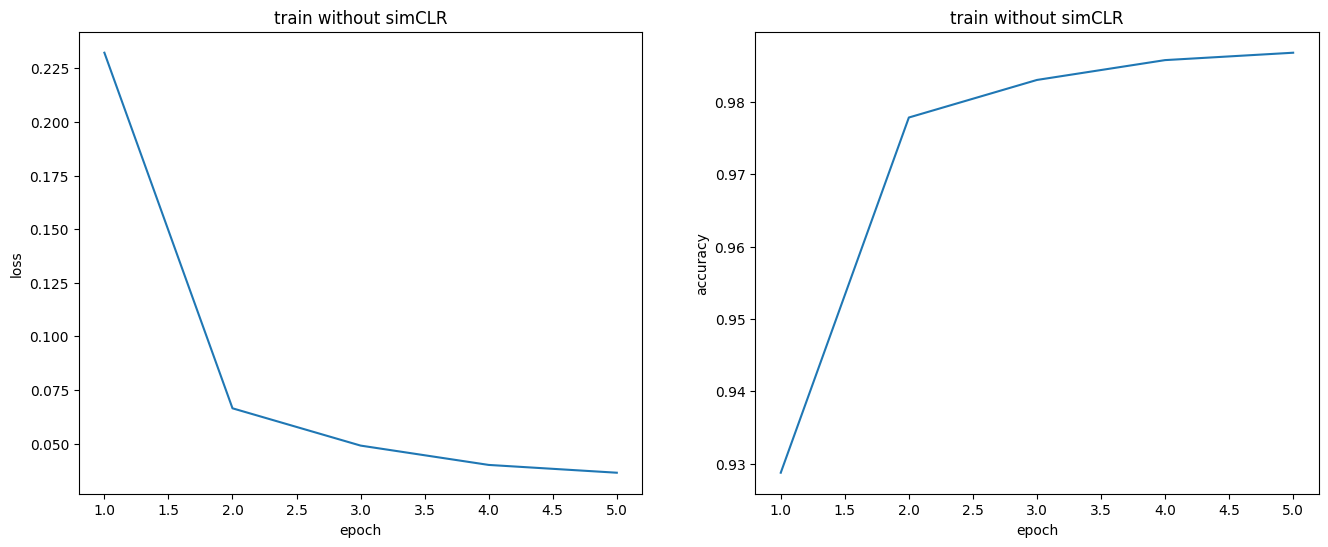

In [88]:
%%time

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

## Test

In [89]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0

    test_loss = []
    test_acc = []
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
        test_loss.append(running_loss / (episode + 1))
        test_acc.append(running_acc / (episode + 1))

    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode

    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    episodes = np.arange(1, test_episode + 1, 1)
    axes[0].plot(episodes, test_loss)
    axes[1].plot(episodes, test_acc)

    axes[0].set_title("test without simCLR")
    axes[0].set_xlabel("episode")
    axes[0].set_ylabel("loss")

    axes[1].set_title("test without simCLR")
    axes[1].set_xlabel("episode")
    axes[1].set_ylabel("accuracy")

In [90]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0182 Acc: 0.9947


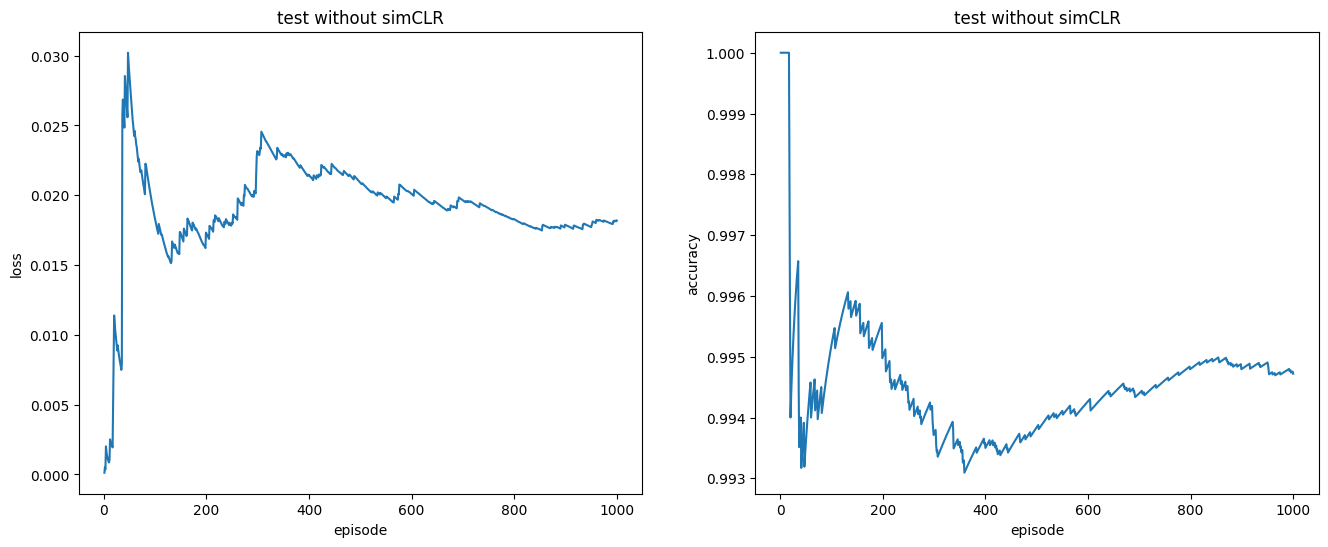

In [91]:
test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

## Test on specific example

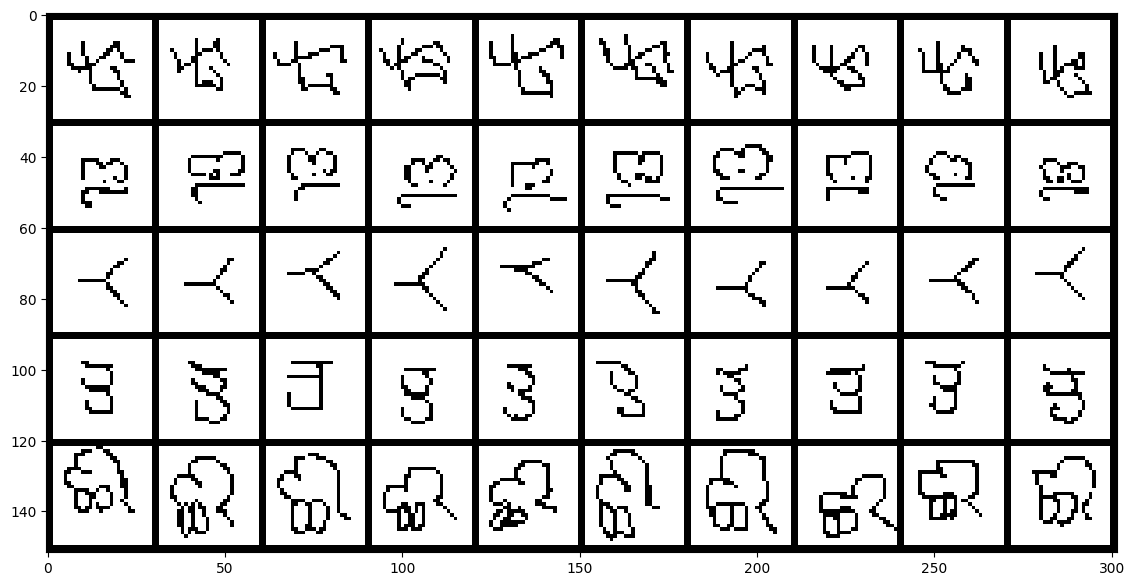

In [92]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

### Задание № 5 - добавьте функцию для визуализации предсказания с тестирования



In [93]:
def predict_visual(sample, model):
    """
    Визуализирует предсказания модели на заданном сэмпле.
    Показывает изображения из query-набора с подписями правильного и предсказанного класса.

    Аргументы:
        sample (dict): Сэмпл с изображениями и метаданными
        model (ProtoNet): Обученная модель ProtoNet
    """
    sample_images = sample['images']
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support].to(device)
    x_query = sample_images[:, n_support:].to(device)

    x_query = x_query.reshape(-1, *x_query.shape[2:])
    z_query = model.encoder(x_query)

    x_support = x_support.reshape(-1, *x_support.shape[2:])
    z_support = model.encoder(x_support)
    z_support = z_support.view(n_way, n_support, -1)
    prototypes = z_support.mean(dim=1)

    dists = torch.cdist(z_query, prototypes)
    log_p_y = F.log_softmax(-dists, dim=1)
    _, y_hat = log_p_y.max(1)

    target_inds = torch.arange(n_way).reshape(n_way, 1).to(device)
    target_inds = target_inds.expand(n_way, n_query).reshape(-1)

    query_images = sample_images[:, n_support:].permute(0, 1, 3, 4, 2).cpu().numpy()

    plt.figure(figsize=(15, 8))

    for i in range(n_way):
        for j in range(n_query):
            plt.subplot(n_way, n_query, i * n_query + j + 1)
            plt.imshow(query_images[i, j])
            plt.title(f"Правильный: {i}\nПредсказанный: {y_hat[i*n_query+j].item()}", fontsize=8)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    acc = (y_hat == target_inds).float().mean().item()
    print(f"Точность на этом сэмпле: {acc*100:.1f}%")



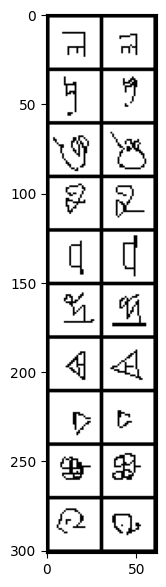

In [96]:
sample_test = extract_sample(10, 1, 1, testx, testy)
display_sample(sample_test['images'])

{'loss': 0.003624850185588002, 'acc': 1.0, 'y_hat': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')}


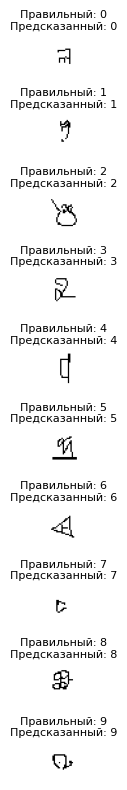

Точность на этом сэмпле: 100.0%


In [97]:
my_loss, my_output = model.set_forward_loss(sample_test)
print(my_output)

predict_visual(sample_test, model)

# Задание 6: Downstream task

## Задание 6.1
Ваша задача обучить заданную вами модель CNN методом SimCLR для набора данных CIFAR10, а затем использовать обученный энкодер для решения задачи классификации.

**Примечание:**
- В качестве базового энкодера можете использовать модель из семинара выше (```resnet18```) или определить свою сеть. **Рекомендуется** использовать уже предобученные сети из [torch zoo](https://pytorch.org/vision/stable/models.html).
- В качестве обучающего множества для задачи классификации воспользуйетсь ```X_test```, ```y_test```, которые были определены в самом начале ноутбука. Создайте обучающую и валидационную выборку.
- В новой CNN для задачи классификации требуется обучить только полносвязные слои после энкодера. Для этого вам потребуется "заморозить" веса энкодера и не учить их. Сделать это можно с помощью команды:
```python
for p in encoder.parameters():
    p.requires_grad = False  
```
- Процесс обучения модели можно взять из предыдущего семинара

## Задание 6.2

Сравните полученный результат обучения c и без использования метода SimCLR.

In [122]:
import torchvision.transforms as transforms
from torchvision.models import resnet18
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [131]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=False, num_workers=2)

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

X_train, X_val, y_train, y_val = train_test_split(
    trainset.data, trainset.targets, test_size=0.2, random_state=42)

In [132]:
class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.n_features = encoder.fc.in_features
        self.encoder.fc = nn.Identity()

        self.projection = nn.Sequential(
            nn.Linear(self.n_features, self.n_features),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim))

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection(h)
        return h, z

In [134]:
def nt_xent_loss(z, temperature=0.5):
    z = F.normalize(z, dim=1)
    sim_matrix = torch.exp(torch.mm(z, z.t()) / temperature)
    mask = ~torch.eye(z.size(0), dtype=torch.bool).to(z.device)
    pos_sim = sim_matrix.masked_select(torch.eye(z.size(0), dtype=torch.bool).to(z.device)).view(z.size(0), -1)
    neg_sim = sim_matrix.masked_select(mask).view(z.size(0), -1)
    loss = -torch.log(pos_sim / neg_sim.sum(dim=1))
    return loss.mean()

def train_simclr(model, trainloader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(trainloader)*epochs)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (x, _) in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}'):
            x = x.to(device)

            x1 = transforms.functional.resize(x, (32, 32))
            x2 = transforms.functional.resize(x, (32, 32))

            optimizer.zero_grad()
            h1, z1 = model(x1)
            h2, z2 = model(x2)
            z = torch.cat([z1, z2], dim=0)
            loss = nt_xent_loss(z)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss/len(trainloader):.4f}')

In [136]:
encoder = resnet18(pretrained=False)
model = SimCLR(encoder).to(device)
train_simclr(model, trainloader, epochs=10)

Epoch 1/10: 100%|██████████| 196/196 [00:22<00:00,  8.65it/s]


Epoch 1, Loss: 4.2852


Epoch 2/10: 100%|██████████| 196/196 [00:18<00:00, 10.63it/s]


Epoch 2, Loss: 4.2673


Epoch 3/10: 100%|██████████| 196/196 [00:19<00:00, 10.20it/s]


Epoch 3, Loss: 4.2660


Epoch 4/10: 100%|██████████| 196/196 [00:19<00:00, 10.28it/s]


Epoch 4, Loss: 4.2648


Epoch 5/10: 100%|██████████| 196/196 [00:20<00:00,  9.71it/s]


Epoch 5, Loss: 4.2635


Epoch 6/10: 100%|██████████| 196/196 [00:21<00:00,  9.02it/s]


Epoch 6, Loss: 4.2614


Epoch 7/10: 100%|██████████| 196/196 [00:18<00:00, 10.41it/s]


Epoch 7, Loss: 4.2597


Epoch 8/10: 100%|██████████| 196/196 [00:19<00:00,  9.96it/s]


Epoch 8, Loss: 4.2582


Epoch 9/10: 100%|██████████| 196/196 [00:18<00:00, 10.34it/s]


Epoch 9, Loss: 4.2572


Epoch 10/10: 100%|██████████| 196/196 [00:19<00:00, 10.26it/s]

Epoch 10, Loss: 4.2568


In [137]:
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(Classifier, self).__init__()
        self.encoder = encoder
        for p in self.encoder.parameters():
            p.requires_grad = False
        self.fc = nn.Linear(encoder.n_features, num_classes)

    def forward(self, x):
        h = self.encoder.encoder(x)
        return self.fc(h)

classifier = Classifier(model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

In [138]:
def train_classifier(model, trainloader, valloader, epochs=10, method = ""):
    best_acc = 0
    type_loss = []
    type_acc = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, Val Acc: {val_acc:.2f}%')
        type_loss.append(running_loss/len(trainloader))
        type_acc.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'task_6_best_classifier.pt')

        wandb.log({
            f"{method}_loss_simclr": type_loss[-1],
            f"{method}_accuracy_simclr": type_acc[-1]
        })

    print(f'Best Validation Accuracy: {best_acc:.2f}%')

    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    epoches = np.arange(1, epochs + 1, 1)
    axes[0].plot(epoches, type_loss)
    axes[1].plot(epoches, type_acc)

    axes[0].set_title(f"{method} with simCLR")
    axes[0].set_xlabel("epoch")
    axes[0].set_ylabel("loss")

    axes[1].set_title(f"{method} with simCLR")
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

Epoch 1/10: 100%|██████████| 157/157 [00:01<00:00, 83.08it/s]


Epoch 1, Loss: 1.9832, Val Acc: 34.42%


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 88.48it/s]


Epoch 2, Loss: 1.8083, Val Acc: 35.81%


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 87.79it/s]


Epoch 3, Loss: 1.7680, Val Acc: 36.25%


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 88.29it/s]


Epoch 4, Loss: 1.7442, Val Acc: 37.55%


Epoch 5/10: 100%|██████████| 157/157 [00:01<00:00, 81.29it/s]


Epoch 5, Loss: 1.7334, Val Acc: 37.49%


Epoch 6/10: 100%|██████████| 157/157 [00:01<00:00, 83.20it/s]


Epoch 6, Loss: 1.7241, Val Acc: 37.61%


Epoch 7/10: 100%|██████████| 157/157 [00:02<00:00, 76.70it/s]


Epoch 7, Loss: 1.7200, Val Acc: 37.39%


Epoch 8/10: 100%|██████████| 157/157 [00:02<00:00, 75.03it/s]


Epoch 8, Loss: 1.7152, Val Acc: 37.09%


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 87.92it/s]


Epoch 9, Loss: 1.7095, Val Acc: 37.35%


Epoch 10/10: 100%|██████████| 157/157 [00:01<00:00, 83.02it/s]


Epoch 10, Loss: 1.7094, Val Acc: 37.43%
Best Validation Accuracy: 37.61%


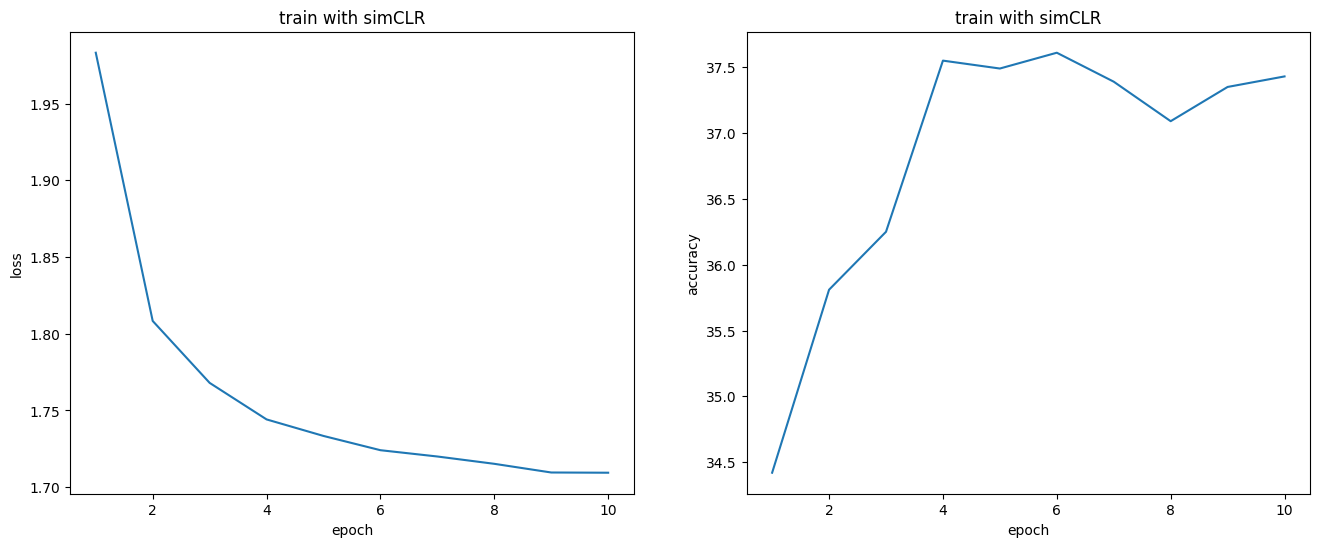

In [139]:
train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2).float(),
    torch.from_numpy(np.array(y_train)))
val_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2).float(),
    torch.from_numpy(np.array(y_val)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)


train_classifier(classifier, train_loader, val_loader, epochs=10, method = "train")

In [140]:
def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f'Test Accuracy: {test_acc:.2f}%')
    return test_acc

simclr_test_acc = evaluate(classifier, testloader)

Test Accuracy: 10.00%


Epoch 1/10: 100%|██████████| 157/157 [00:06<00:00, 25.15it/s]


Epoch 1, Loss: 1.4319, Val Acc: 43.59%


Epoch 2/10: 100%|██████████| 157/157 [00:06<00:00, 23.18it/s]


Epoch 2, Loss: 1.0627, Val Acc: 56.40%


Epoch 3/10: 100%|██████████| 157/157 [00:06<00:00, 25.45it/s]


Epoch 3, Loss: 0.8719, Val Acc: 66.48%


Epoch 4/10: 100%|██████████| 157/157 [00:06<00:00, 25.77it/s]


Epoch 4, Loss: 0.7288, Val Acc: 63.79%


Epoch 5/10: 100%|██████████| 157/157 [00:06<00:00, 25.43it/s]


Epoch 5, Loss: 0.6097, Val Acc: 63.08%


Epoch 6/10: 100%|██████████| 157/157 [00:06<00:00, 25.46it/s]


Epoch 6, Loss: 0.5196, Val Acc: 59.70%


Epoch 7/10: 100%|██████████| 157/157 [00:06<00:00, 22.81it/s]


Epoch 7, Loss: 0.4224, Val Acc: 49.00%


Epoch 8/10: 100%|██████████| 157/157 [00:06<00:00, 25.56it/s]


Epoch 8, Loss: 0.3426, Val Acc: 68.14%


Epoch 9/10: 100%|██████████| 157/157 [00:06<00:00, 24.47it/s]


Epoch 9, Loss: 0.2872, Val Acc: 59.65%


Epoch 10/10: 100%|██████████| 157/157 [00:06<00:00, 25.36it/s]


Epoch 10, Loss: 0.2379, Val Acc: 68.13%
Best Validation Accuracy: 68.14%
Test Accuracy: 10.00%

Сравнение результатов:
Точность с предобучением SimCLR: 10.00%
Точность без предобучения: 10.00%
Улучшение: 0.00%


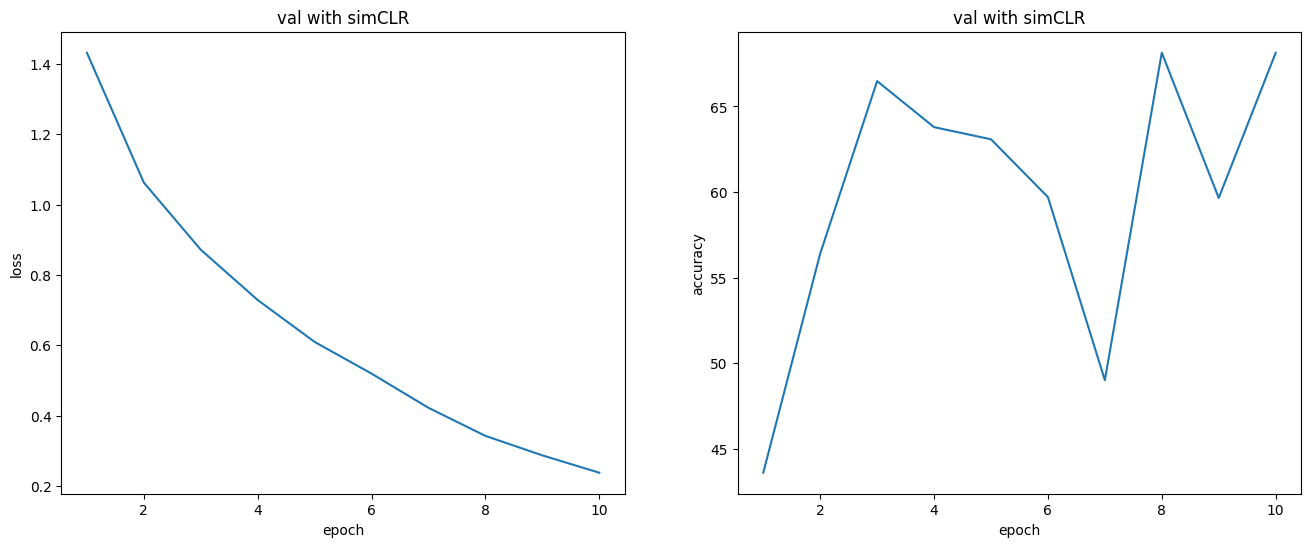

In [141]:
class BaseClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseClassifier, self).__init__()
        self.encoder = resnet18(pretrained=False)
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, num_classes)

    def forward(self, x):
        return self.encoder(x)

base_classifier = BaseClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_classifier.parameters(), lr=1e-3)

train_classifier(base_classifier, train_loader, val_loader, epochs=10, method = "val")
base_test_acc = evaluate(base_classifier, testloader)

print("\nСравнение результатов:")
print(f"Точность с предобучением SimCLR: {simclr_test_acc:.2f}%")
print(f"Точность без предобучения: {base_test_acc:.2f}%")
print(f"Улучшение: {simclr_test_acc - base_test_acc:.2f}%")

In [142]:
wandb.finish()

train_accuracy,▁▇███
train_accuracy_simclr,▁▄▅████▇▇█
train_loss,█▂▁▁▁
train_loss_simclr,█▄▂▂▂▁▁▁▁▁
val_accuracy_simclr,▁▅█▇▇▆▃█▆█
val_loss_simclr,█▆▅▄▃▃▂▂▁▁
train_accuracy,0.98682
train_accuracy_simclr,37.43
train_loss,0.03639
train_loss_simclr,1.7094
val_accuracy_simclr,68.13
